# Network Simulation Evaluation

First import all needed libraries and set global constants and configurations:

In [1]:
import glob
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1/2.54
linewidth = 14.6979 * cm # line width in TuDa template
sns.set_theme(context='paper', style='whitegrid', palette='deep', rc={'figure.figsize':(linewidth, 10*cm)})

We define two functions to read in the `clab` output:

- `get_pidstat_df` reads in pidstat output and adds a duration column as well as a node column to identify the reading
- `get_network_df` reads in network traffic logs and adds a duration column as well as a node column to identify the reading. Also, some units are transformed to make the stats more readable

In [37]:
correct_log_header = "Time          UID       PID    %usr %system  %guest   %wait    %CPU   CPU  minflt/s  majflt/s     VSZ     RSS   %MEM   kB_rd/s   kB_wr/s kB_ccwr/s iodelay  Command\n"
del_col = ["Command", "PID", "%system","%guest", "%wait"]

def get_pidstat_df(scen_dir, nodes):
    pidstat_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"net-sim/eval/{scen_dir}/results-*/n*/pidstat-{node_name}.csv.log"):

            # change header since Pandas will not be able to parse it correctly
            with open(filepath, "r") as fh:
                lines = fh.readlines()
            lines[0] = correct_log_header
            # store it in a temporary file object so we don't need to
            # modify the (potentially protected) original file
            data = io.StringIO("".join(lines))

            df = pd.read_fwf(data)
            df["duration"] = df["Time"] - df["Time"][0]
            df["node"] = node_name
            # for c in del_col:
            #        del df[c]
            pidstat_df = pd.concat([pidstat_df, df], ignore_index=True)
            
    return pidstat_df

In [38]:
csv_header = ["timestamp", "iface_name", "bytes_out/s", "bytes_in/s", "bytes_total/s", "bytes_in", "bytes_out", "packets_out/s",
    "packets_in/s", "packets_total/s", "packets_in", "packets_out", "errors_out/s", "errors_in/s", "errors_in", "errors_out"]

def get_network_df(scen_dir, nodes):
    net_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"net-sim/eval/{scen_dir}/results-*/n*/net-{node_name}.log"):
            df = pd.read_csv(filepath, sep=";", names=csv_header)
            df["duration"] = (df["timestamp"] - df["timestamp"][0]).round(0).astype(int)
            df["node"] = node_name
            df["kb_in/s"] = df["bytes_in/s"] / 1000
            df["kb_out/s"] = df["bytes_out/s"] / 1000
            df["kb_total/s"] = df["bytes_total/s"] / 1000
            
            net_df = pd.concat([net_df, df], ignore_index=True)
    
    return net_df

### Szenario `1k`

In this scenario, three nodes start off with no connection between them. `n1` and `n3` are each pre-loaded with 1,000 articles that are in the DB of the *moNNT.py Server* and in the store of the *dtnd*.

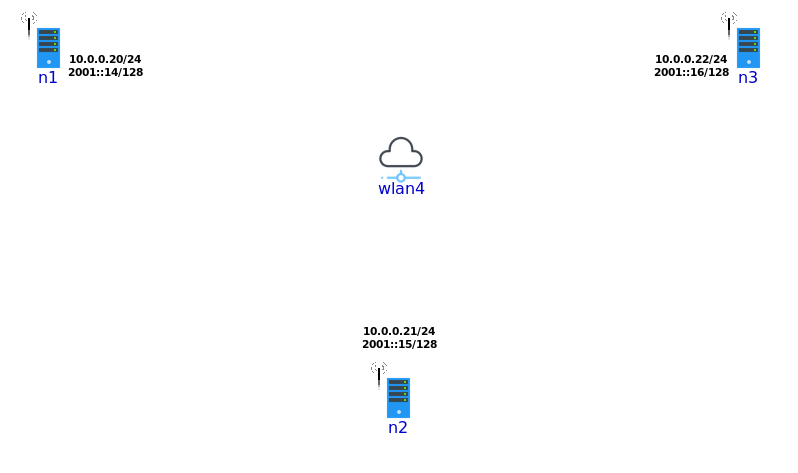

Then the simulation runs through the following steps:

1. Wait 10 seconds
2. `n2` moves into proximity of `n1` -- after a short period both *dtnd* instances will discover eachother and exchange previously unknown bundles, which will then be pushed to the respective *moNNT.py* instance.
3. Wait 10 seconds
4. `n2` moves into proximity of `n3` -- analog to step 2.
5. Wait 10 seconds

In [51]:
nodes = ["n1", "n2", "n3"]
scen_dir = "1k"

#### CPU utilization, memory usage, and storage writes

In [56]:
pidstat_df = get_pidstat_df(scen_dir=scen_dir, nodes=nodes)

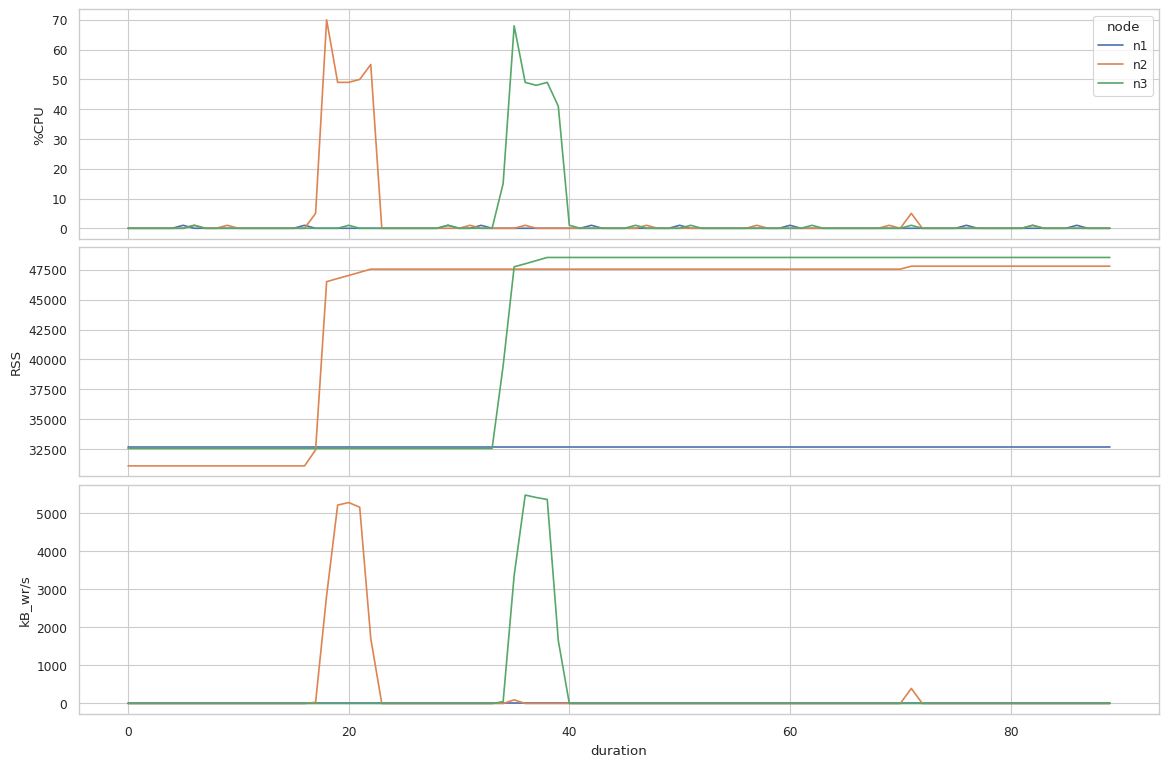

In [57]:
stats = ["%CPU", "RSS", "kB_wr/s"]
cols, rows = [1, len(stats)]

fig, ax = plt.subplots(rows, cols, figsize=(2*linewidth, 2*rows*3.2*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(stats):
    sns.lineplot(data=pidstat_df, x="duration", y=g, hue="node", ax=ax[i])
    if i > 0:
        ax[i].get_legend().remove()

# save legend for later on
global_handles, global_labels = ax[0].get_legend_handles_labels()

In [8]:
fig.savefig("ch6_1k_cpu_str.pdf")

#### Network transfers

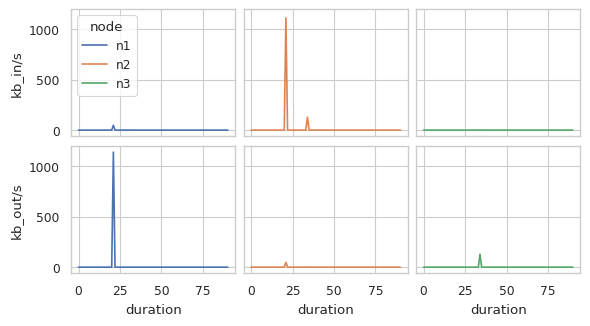

In [54]:
net_df = get_network_df(scen_dir=scen_dir, nodes=nodes)
y_cols = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]

fig, ax = plt.subplots(2, 3, figsize=(linewidth, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, y_col in enumerate(y_cols):
    for j, n in enumerate(nodes):
        sns.lineplot(
            data=net_df[(net_df["iface_name"] == "total") & (net_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j], ax=ax[i][j])
_ = ax[0][0].legend(title="node", handles=global_handles, labels=global_labels, loc='upper left')

In [10]:
fig.savefig("ch6_1k_net.pdf")

### Szenario `always_on`

In this scenario, two nodes are within range of eachother continuously. On each node, news clients send articles every 0.3 seconds after an initial delay of 2 seconds. These are first processed by the local moNNT.py and dtnd instances before being sent to the other node, where they are also processed and integrated into the database, respectively store.

In [43]:
nodes = ["n1", "n2"]
scen_dir = "always_on"

#### CPU utilization, memory usage, and storage writes

In [44]:
pidstat_df = get_pidstat_df(scen_dir=scen_dir, nodes=nodes)

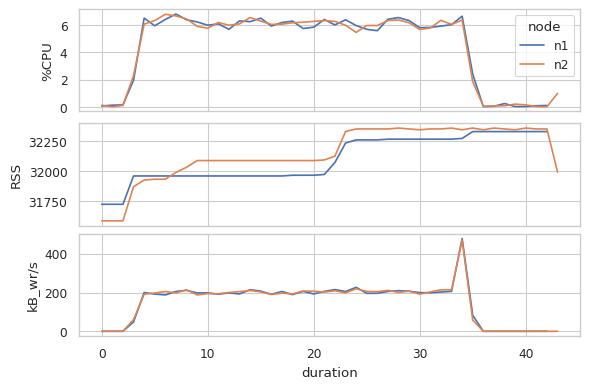

In [45]:
stats = ["%CPU", "RSS", "kB_wr/s"]
cols, rows = [1, len(stats)]

fig, ax = plt.subplots(rows, cols, figsize=(linewidth, rows*3.2*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(stats):
    sns.lineplot(data=pidstat_df, x="duration", y=g, hue="node", ax=ax[i], errorbar=None)
    if i > 0:
        ax[i].get_legend().remove()

# save legend for later on
global_handles, global_labels = ax[0].get_legend_handles_labels()

In [20]:
fig.savefig("ch6_always_on_cpu_str.pdf")

#### Network transfers

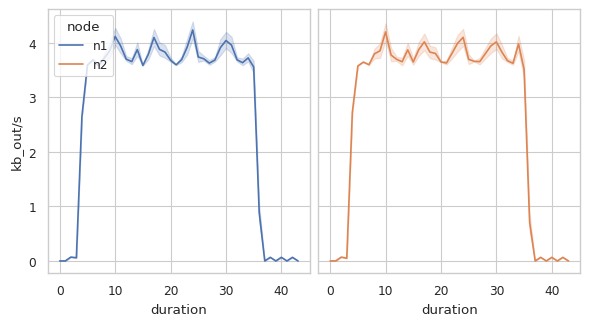

In [47]:
net_df = get_network_df(scen_dir=scen_dir, nodes=nodes)
# y_cols = ["kb_in/s", "kb_out/s"]  # , 
y_cols = ["bytes_total/s"]

fig, ax = plt.subplots(1, len(nodes), figsize=(linewidth, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, n in enumerate(nodes):
    sns.lineplot(
        data=net_df[(net_df["iface_name"] == "total") & (net_df["node"] == n)],
        x="duration", y=y_col, color=sns.color_palette()[i], ax=ax[i])
_ = ax[0].legend(title="node", handles=global_handles, labels=global_labels, loc='upper left')

In [23]:
fig.savefig("ch6_always_on_net.pdf")

### Szenario `busynode`

In [48]:
nodes = ["n1", "n2", "n3"]
scen_dir_nozip = "busynode_nozip"
scen_dir_zip = "busynode_zip"
pidstat_nozip_df = get_pidstat_df(scen_dir=scen_dir_nozip, nodes=nodes)
pidstat_zip_df = get_pidstat_df(scen_dir=scen_dir_zip, nodes=nodes)

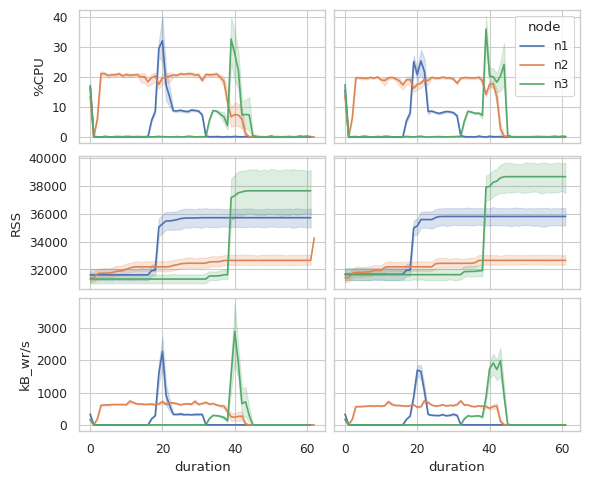

In [49]:
cols, rows = [2, 3]

fig, ax = plt.subplots(rows, cols, figsize=(linewidth, 3*4*cm), constrained_layout=True, sharex=True, sharey="row")
for i, g in enumerate(["%CPU", "RSS", "kB_wr/s"]):
    sns.lineplot(data=pidstat_nozip_df, x="duration", y=g, hue="node", ax=ax[i][0], legend=False)
    sns.lineplot(data=pidstat_zip_df, x="duration", y=g, hue="node", ax=ax[i][1])
    if i > 0:
        ax[i][1].get_legend().remove()

In [79]:
fig.savefig("ch6_busynode_cpu_str.pdf")

#### Network transfers

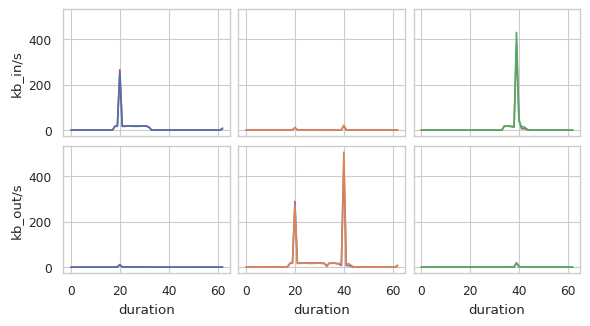

In [50]:
net_nozip_df = get_network_df(scen_dir=scen_dir_nozip, nodes=nodes)
net_zip_df = get_network_df(scen_dir=scen_dir_zip, nodes=nodes)
y_cols = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]

fig, ax = plt.subplots(2, 3, figsize=(linewidth, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, y_col in enumerate(y_cols):
    for j, n in enumerate(nodes):
        sns.lineplot(
            data=net_nozip_df[(net_nozip_df["iface_name"] == "total") & (net_nozip_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j+3], ax=ax[i][j], errorbar=None)
        sns.lineplot(
            data=net_zip_df[(net_zip_df["iface_name"] == "total") & (net_zip_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j], ax=ax[i][j], errorbar=None)

# _ = ax[0][0].legend(current_handles, ["node", "n1", "n2", "n3"], loc="upper left")

In [76]:
def count_saved(file_path) -> tuple[int]:
    num_saved = 0
    file_list = glob.glob(file_path)
    for f in file_list:
        with open(f, 'r') as fh:
            n = fh.read().count("Created new entry with id")
        num_saved += n
    return len(file_list), num_saved

n1nz_cnt, n1_nozip = count_saved("net-sim/eval/busynode_nozip/results-*/n*/*monntpy_n1.log")
n3nz_cnt, n3_nozip = count_saved("net-sim/eval/busynode_nozip/results-*/n*/*monntpy_n3.log")
n1z_cnt, n1_zip = count_saved("net-sim/eval/busynode_zip/results-*/n*/*monntpy_n1.log")
n3z_cnt, n3_zip = count_saved("net-sim/eval/busynode_zip/results-*/n*/*monntpy_n3.log")

Average saved articles per node per simulation run:

In [77]:
n1nz_avg = n1_nozip / n1nz_cnt
n3nz_avg = n3_nozip / n3nz_cnt
n1z_avg = n1_zip / n1z_cnt
n3z_avg = n3_zip / n3z_cnt

print(f"      |  no zip       zip")
print("------+-------------------")
print(f"   n1 |  {n1nz_avg:3.2f}    {n1z_avg:3.2f}")
print(f"   n3 |  {n3nz_avg:3.2f}    {n3z_avg:3.2f}")
print("------+-------------------")
print(f"Total |  {(n1nz_avg+n3nz_avg):3.2f}    {(n1z_avg+n3z_avg):3.2f}")

      |  no zip       zip
------+-------------------
   n1 |  264.70    261.40
   n3 |  368.96    392.98
------+-------------------
Total |  633.66    654.38
